# 机器学习纳米学位
## 监督学习
## 项目2: 为*CharityML*寻找捐献者


监督学习项目： 使用1994年美国人口普查收集的数据，选用几个监督学习算法以准确地建模被调查者的收入。将被调查者按年收入是否超过50000美元分为两类。

主要目标：
1. 特征工程：为了更好的训练模型，需要对数据进行哪些预处理？ 包括特征缩放（对数转换、正规化）、清理异常点等
2. 非数值特征转为数值特征： One-Hot Encoding / Label Encoding
3. 分类器模型的评估标准： F-beta Score。有个beta参数，表示precision和recall的比重。
4. 监督学习算法学习： GaussianNB、SVC、DecisionTreeClassifier、Boosting、SGDC、K-means、Logistic等等，原理是什么？有哪些特点？
5. 选择一个监督学习算法使用数据训练模型、调参
6. 特征分析：利用学习到的模型评估特征重要性。

In [6]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()

# 导入附加的可视化代码visuals.py
import visuals as vs

# 为notebook提供更加漂亮的可视化
%matplotlib inline

In [4]:
# 观察数据
data = pd.read_csv("census.csv")
display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [9]:
# 数据的大致分布
n_records = len(data)
n_greater_50k = len(data[data['income'] == '>50K'])
n_at_most_50k = len(data[data['income'] == '<=50K'])
greater_percent = 100.0 * n_greater_50k / n_records

print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [12]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

### 对于倾斜的数据使用Log转换

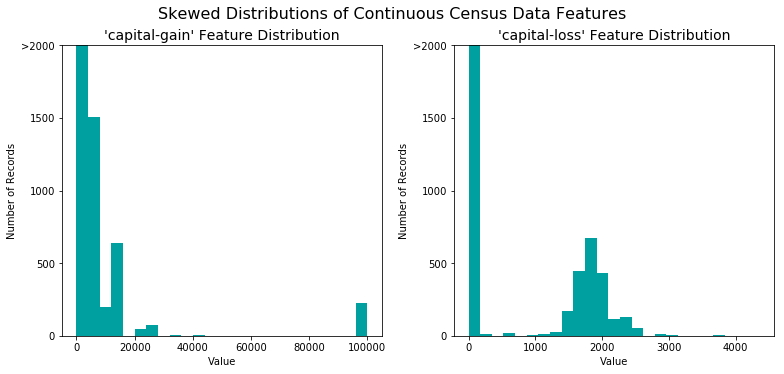

In [13]:
# 可视化 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw)

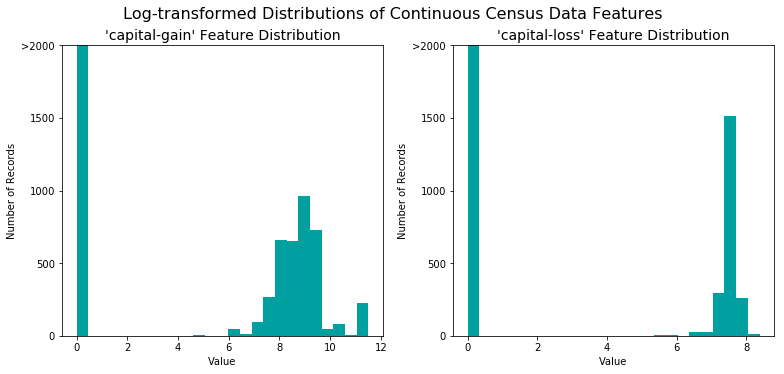

In [14]:
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化对数转换后 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw, transformed = True)

### 规一化数字特征

In [15]:
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### 非数字特征转换为数字特征

In [17]:
# 使用pandas.get_dummies()对'features_raw'数据进行独热编码
features = pd.get_dummies(features_raw)

# TODO：将'income_raw'编码成数字值
income = (income_raw == '>50K').astype('int')

# 打印经过独热编码之后的特征数量
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# # 移除下面一行的注释以观察编码的特征名字
# print (encoded)

103 total features after one-hot encoding.


### 混洗和切分数据

In [19]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0,
                                                    stratify = income)
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
                                                    stratify = y_train)

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 28941 samples.
Validation set has 7236 samples.
Testing set has 9045 samples.


### 评价方法
*CharityML*通过他们的研究人员知道被调查者的年收入大于\$50,000最有可能向他们捐款。因为这个原因*CharityML*对于准确预测谁能够获得\$50,000以上收入尤其有兴趣。这样看起来使用**准确率**作为评价模型的标准是合适的。另外，把*没有*收入大于\$50,000的人识别成年收入大于\$50,000对于*CharityML*来说是有害的，因为他想要找到的是有意愿捐款的用户。这样，我们期望的模型具有准确预测那些能够年收入大于\$50,000的能力比模型去**查全**这些被调查者*更重要*。我们能够使用**F-beta score**作为评价指标，这样能够同时考虑查准率和查全率：

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

$$ F_{\beta} = \frac{1 + \beta^2}{ \frac{1}{precision} + \frac{\beta^2}{recall}  } $$

$\beta < 1$ 时 强调查准率，  $\beta > 1$ 时强调查全率。 $\beta \to 0$ 时，即查准率； $\beta \to \infty $时即查全率

尤其是，当 $\beta = 0.5$ 的时候更多的**强调查准率**，这叫做**F$_{0.5}$ score** （或者为了简单叫做F-score）。

### 预测基准线： 全部预测为1

In [20]:
accuracy = 1.0 * sum(y_val) / len(y_val)
precision = accuracy
recall = 1.0
beta = 0.5
fscore = (1 + beta * beta) * precision * recall / (beta * beta * precision + recall)

print ("Naive Predictor on validation data: \n \
    Accuracy score: {:.4f} \n \
    Precision: {:.4f} \n \
    Recall: {:.4f} \n \
    F-score: {:.4f}".format(accuracy, precision, recall, fscore))

Naive Predictor on validation data: 
     Accuracy score: 0.2478 
     Precision: 0.2478 
     Recall: 1.0000 
     F-score: 0.2917


### 选择监督学习算法

#### 高斯朴素贝叶斯 (GaussianNB)
[朴素贝叶斯分类器](https://zh.wikipedia.org/wiki/%E6%9C%B4%E7%B4%A0%E8%B4%9D%E5%8F%B6%E6%96%AF%E5%88%86%E7%B1%BB%E5%99%A8) 是文本分类问题的一个基准方法。文本分类是以词频为特征判断文本所属类别或其他（如垃圾邮件、合法性、体育或政治等等）的问题。

优点：
模型易于实现，并且适用于维度大的数据，只需要根据少量的训练数据估计出必要的参数（变量的均值和方差）。数据数量 >> 特征数量，且特征之间满足不相关条件时，模型表现最好。

缺点：
由于数据特征之间不相关是一个过于简化的假设条件，这种分类方法被称为**naive**贝叶斯分类器。当数据特征之间具有相关性的时候，会对性能造成损失。但即使条件不满足的时候，朴素贝叶斯分类器在很多复杂的现实情形中仍能够取得相当好的效果。

模型简单易于实现，可以用来作为分类基准方法（baseline）。

#### 支持向量机 (SVM)
[支持向量机](https://zh.wikipedia.org/wiki/%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%9C%BA) 可以用于文本和超文本的分类，在归纳和直推方法中都可以显著减少所需要的有类标的样本数。

优点：
1. 在非线性可分问题上表现优秀。
2. SVM分类尽量保持与样本间距离的性质导致它抗攻击的能力最强。

当待分类数据有明显界限的时候，SVM模型表现最好。

缺点：
1. 如果数据overlap或noise严重，则模型表现较差，且容易过拟合。 
2. SVM运算复杂，训练速度较慢。

当前数据集大小适中，且维度也并不高，可以用SVM分类器尝试一下。

#### 集成方法 (AdaBoost)

[AdaBoost](https://en.wikipedia.org/wiki/Boosting_(machine_learning\\)) 自适应增强方法是集成方法的一种。可以用于人脸检测（face detection），用来区分人脸和背景（background）。

优点：
AdaBoost的优点是自带特征选择（feature selection），只使用在训练集中发现的有效的特征。这就降低了分类时需要计算的特征数量，也在一定程度上解决了高维数据难以理解的问题。AdaBoost方法的自适应在于：前一个分类器分错的样本会被提升权重，用来训练下一个分类器。因此AdaBoost对数据噪声或异常点比较敏感，需要对数据进行预处理。当数据噪声较小或无异常点的时候，AdaBoost模型表现最好。

缺点：
AdaBoost迭代次数也就是弱分类器数目不太好设定，可以使用交叉验证来进行确定。由于模型对数据噪声敏感，当数据不平衡或者噪声较大时，模型表现较差。

数据集的特征数量和类型都比较复杂，可以使用AdaBoost模型分析特征重要性。

### 训练评估模型

使用上述三个算法

使用1%， 10%， 100%的训练数据训练模型


In [22]:

from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_val: features validation set
       - y_val: income validation set
    '''
    
    results = {}
    
    # 可以随机筛选
#     sampled_row = pd.Series(X_train.index).sample(n = sample_size)
#     temp_x = X_train.loc[sampled_row, :]
#     temp_y = y_train.loc[sampled_row, :]
#     start = time()
#     learner = learner.fit(temp_x, temp_y)
#     end = time()

    start = time() # 获得程序开始时间
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # 获得程序结束时间
    
    # TODO：计算训练时间
    results['train_time'] = end - start
    
    # TODO: 得到在验证集上的预测值
    #       然后得到对前300个训练数据的预测结果
    start = time() # 获得程序开始时间
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train[:300])
    end = time() # 获得程序结束时间
    
    # TODO：计算预测用时
    results['pred_time'] = end - start
            
    # TODO：计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO：计算在验证上的准确率
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    
    # TODO：计算在最前面300个训练数据上的F-score
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO：计算验证集上的F-score
    results['f_val'] = fbeta_score(y_val, predictions_val, 0.5)
       
    # 成功
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # 返回结果
    return results

GaussianNB trained on 289 samples.
GaussianNB trained on 2894 samples.
GaussianNB trained on 28941 samples.
SVC trained on 289 samples.
SVC trained on 2894 samples.
SVC trained on 28941 samples.
AdaBoostClassifier trained on 289 samples.
AdaBoostClassifier trained on 2894 samples.
AdaBoostClassifier trained on 28941 samples.


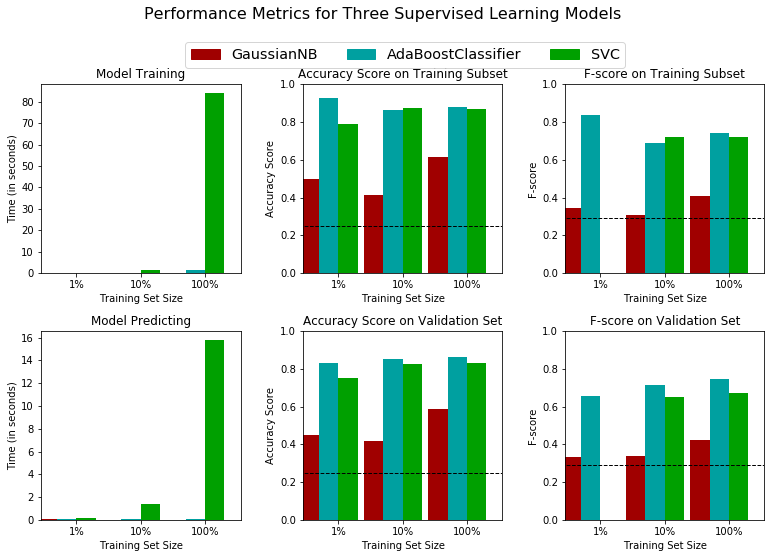

In [23]:
# TODO：从sklearn中导入三个监督学习模型
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# TODO：初始化三个模型
clf_A = GaussianNB()
clf_B = SVC(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = len(X_train) / 100
samples_10 = len(X_train) / 10
samples_100 = len(X_train)

# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

# 对选择的三个模型得到的评价结果进行可视化
vs.evaluate(results, accuracy, fscore)

从预测/训练时间来说， AdaBoost模型和GaussianNB模型用时都很短，而SVC模型训练/预测非常耗时。 从测试集和验证集的准确度来看， AdaBoost模型略优于SVC模型，明显优于GaussianNB。此外，GaussianNB 和SVC模型在数据维度较高时有较明显优势，所以常用语基于词频的文本分类问题中，这个问题所用到的特征类型比较复杂，且特征维度并不高。所以综合训练/预测用时、准确度指标和数据类型，最终选择AdaBoost模型。

----
## 优化模型： 网格搜索



AdaBoost模型使用集成方法，即使用一组简单的分类器，最终组合成一个效果很好的分类器。训练AdaBoost模型使用迭代方法：每次找到一个最优的简单分类器（只使用一个特征）分类数据。对于错误的分类数据，增加其权重，用于下一个简单分类器的训练。迭代次数等于使用的简单分类器的个数。这样，在每次迭代后，都会减少分类错误，并且在训练过程中可以得到特征的选择顺序，可以表示特征的重要程度。

预测的时候，通过综合（加权平均）各简单分类器的结果得到最终分类。

In [24]:
# TODO：导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier

# TODO：初始化分类器
clf = AdaBoostClassifier(random_state=0)

# TODO：创建你希望调节的参数列表
parameters = {'n_estimators': [50, 250, 500], 'learning_rate': [1.0, 1.5, 2.0]}

# TODO：创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_obj.fit(X_train, y_train)

# 得到estimator
best_clf = grid_obj.best_estimator_

# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# 汇报调参前和调参后的分数
print(best_clf)
print('-----\n')

print ("Unoptimized model\n------")
print ("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=500, random_state=0)
-----

Unoptimized model
------
Accuracy score on validation data: 0.8648
F-score on validation data: 0.7443

Optimized Model
------
Final accuracy score on the validation data: 0.8760
Final F-score on the validation data: 0.7643


### 模型评估


#### 结果:
 
| 评价指标         | 天真预测器           | 未优化的模型        | 优化的模型        |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| 准确率          |    0.2478           |  0.8648           |  0.8760               |
| F-score        |    0.2917           |  0.7443           |  0.7643         |

 最优模型在测试数据上的准确率为0.8750，F-score为0.7643，分数比没有优化的模型好，远高于天真预测器。最优模型使用的参数为n_estimators=500，learning_rate=1.5适中。

----
## 特征的重要性

在数据上（比如我们这里使用的人口普查的数据）使用监督学习算法的一个重要的任务是决定哪些特征能够提供最强的预测能力。专注于少量的有效特征和标签之间的关系，我们能够更加简单地理解这些现象，这在很多情况下都是十分有用的。在这个项目的情境下这表示我们希望选择一小部分特征，这些特征能够在预测被调查者是否年收入大于\$50,000这个问题上有很强的预测能力。


预先猜测特征重要性：

- 特征1: education-level，受教育程度越高，单位时间收入相对来说也应当越高
- 特征2: hours-per-week， 工作时间越长，收入越高
- 特征3: age，年龄越大，工作经验较多，单位时间收入越高
- 特征4: work-class，工作性质与收入相关性较大
- 特征5: occupation， 同工作性质，与收入相关性较大

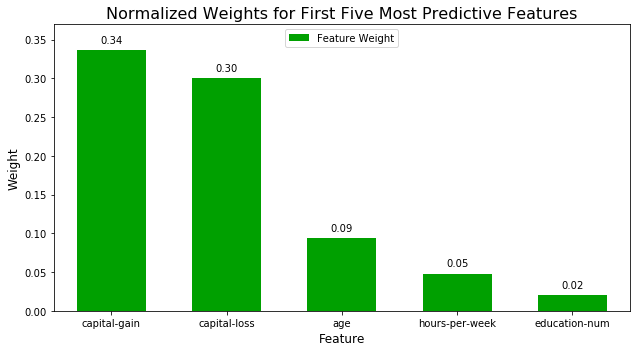

In [25]:
model = AdaBoostClassifier(random_state=0, n_estimators=500, learning_rate=1.5).fit(X_train, y_train)
importances = model.feature_importances_

# 绘图
vs.feature_plot(importances, X_train, y_train)

age、hours-per-week和education-num与猜测的一致（education-num其实是education-level 的LabelEncoding，按受教育程度从低到高顺序，赋值范围为 1 ~ 16）。work-class、occupation，与education-level一样，都是分类类型的特征，在One-Hot Encoding之后被打散成新的特征，所以没有进入前五重要的特征中。

最重要的两个特征是 capital-gain和capital-loss，表示投资利得和投资损失。这两个特征远比普通收入更能区分个人的收入情况。猜测时没有选择这两个特征是因为对这两个特征的意义不是很清楚，现在看来，投资利得或投资损失应当占个人收入的很大一部分，更能反应一个人的整体收入情况。

### 特征选择

如果我们只是用可用特征的一个子集的话模型表现会怎么样？通过使用更少的特征来训练，在评价指标的角度来看我们的期望是训练和预测的时间会更少。从上面的可视化来看，我们可以看到前五个最重要的特征贡献了数据中**所有**特征中超过一半的重要性。这提示我们可以尝试去**减小特征空间**，简化模型需要学习的信息。下面代码单元将使用你前面发现的优化模型，并**只使用五个最重要的特征**在相同的训练集上训练模型。

In [26]:
# 导入克隆模型的功能
from sklearn.base import clone

# 减小特征空间
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_val_reduced = X_val[X_val.columns.values[(np.argsort(importances)[::-1])[:5]]]

# 在前面的网格搜索的基础上训练一个“最好的”模型
clf_on_reduced = (clone(best_clf)).fit(X_train_reduced, y_train)

# 做一个新的预测
reduced_predictions = clf_on_reduced.predict(X_val_reduced)

# 对于每一个版本的数据汇报最终模型的分数
print ("Final Model trained on full data\n------")
print ("Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, reduced_predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on validation data: 0.8760
F-score on validation data: 0.7643

Final Model trained on reduced data
------
Accuracy on validation data: 0.8456
F-score on validation data: 0.7190


最终模型在只用5个特征的数据上的表现略差于使用所有特征的模型，但是大大简化了训练中的特征选择。有些特征，如 education-level和education-num 是完全相关的，education-level 在One-Hot Encoding之后被打散成多个特征，实际上都是无用的。 如果训练时间是一个要考虑的因素，我会考虑使用部分特征的数据作为训练集。

## 模型最终评估（测试集）

In [27]:
#TODO test your model on testing data and report accuracy and F score

predictions_test = best_clf.predict(X_test)
print ("Best Model trained on full data\n------")
print ("Accuracy on test data: {:.4f}".format(accuracy_score(y_test, predictions_test)))
print ("F-score on test data: {:.4f}".format(fbeta_score(y_test, predictions_test, beta = 0.5)))

Best Model trained on full data
------
Accuracy on test data: 0.8693
F-score on test data: 0.7541


**回答：**  AdaBoost模型的一个优点在于每次迭代都能减少训练误差，并且不容易产生过拟合，泛化误差也较小。所以使用AdaBoost模型在测试集上评分，其结果与训练集上的得分很接近。

> **注意：** 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。

In [18]:
edu = list(set(zip(list(data.education_level.values), list(data['education-num'].values))))
edu.sort(key=lambda x: x[1])
edu

[(' Preschool', 1.0),
 (' 1st-4th', 2.0),
 (' 5th-6th', 3.0),
 (' 7th-8th', 4.0),
 (' 9th', 5.0),
 (' 10th', 6.0),
 (' 11th', 7.0),
 (' 12th', 8.0),
 (' HS-grad', 9.0),
 (' Some-college', 10.0),
 (' Assoc-voc', 11.0),
 (' Assoc-acdm', 12.0),
 (' Bachelors', 13.0),
 (' Masters', 14.0),
 (' Prof-school', 15.0),
 (' Doctorate', 16.0)]

In [19]:
# feature_importances = zip(list(X_train.columns.values), importances)
# feature_importances.sort(key=lambda x: x[1], reverse=True)
# feature_importances

In [21]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
trace1 = go.Histogram(x = X_train[y_train==0]['education-num'].values, name='0') # 这里选择画出柱状图
trace2 = go.Histogram(x = X_train[y_train==1]['education-num'].values, name='1')
data = [trace1, trace2]
iplot(data)